In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

import plot_spatial_histograms as histplot

%matplotlib inline

In [3]:
adata_human = ad.read_h5ad(
    '/data/cirro_files_hmba_human_20250624/hmba_release_format_human_cirro_h5ad_20250624.h5ad',
)
adata_human

AnnData object with n_obs × n_vars = 6992128 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15',

In [4]:
adata_human.obs['Neighborhood'].value_counts()

Neighborhood
Nonneuron               5362208
Subpallium GABA         1455146
Adjacent                 133970
Glut Sero Dopa            37610
Subpallium GABA-Glut       3194
Name: count, dtype: int64

In [5]:
# let's take an example section
z = 6
adata_test_sec = adata_human[adata_human.obs['z_order']==z].copy()

# and just take the astrocytes to see what pops out!
adata_test_sec_astro = adata_test_sec[adata_test_sec.obs['Group'] == 'Astrocyte'].copy()

In [6]:
# obs_field = 'Cluster'

# for cat in adata_test_sec_astro.obs[obs_field].cat.categories[:1]:
#     print(cat)
#     H, xedges, yedges = histplot.calculate_2D_histogram(
#         adata_test_sec_astro, 
#         obs_field=obs_field, 
#         category=cat, 
#         binsize=300,
#     )

#     fig_cat, _, _ = histplot.plot_2D_histogram(
#         H, 
#         xedges, 
#         yedges, 
#         title=f'{obs_field}: {cat}\nz={z}', 
#         cmap='viridis',
#         figsize=(8,8),
#         highlight_zero_color='black',  # highlight zero counts in black
#     )

#     # Save the figure
#     os.makedirs('/results/figures', exist_ok=True)
#     fig_cat.savefig(f'/results/figures/astrocyte_histogram_absolute_count_z{z}_{obs_field}_{cat}.png', dpi=300)

## What is the distribution of total astrocytes per bin?

I care about both:
1. What does this look like in a 2D spatial histogram?
2. What does the 1D, non-spatial distribution look like?
    - Is it bimodal, i.e. one mode for GM and one for WM?
    - 

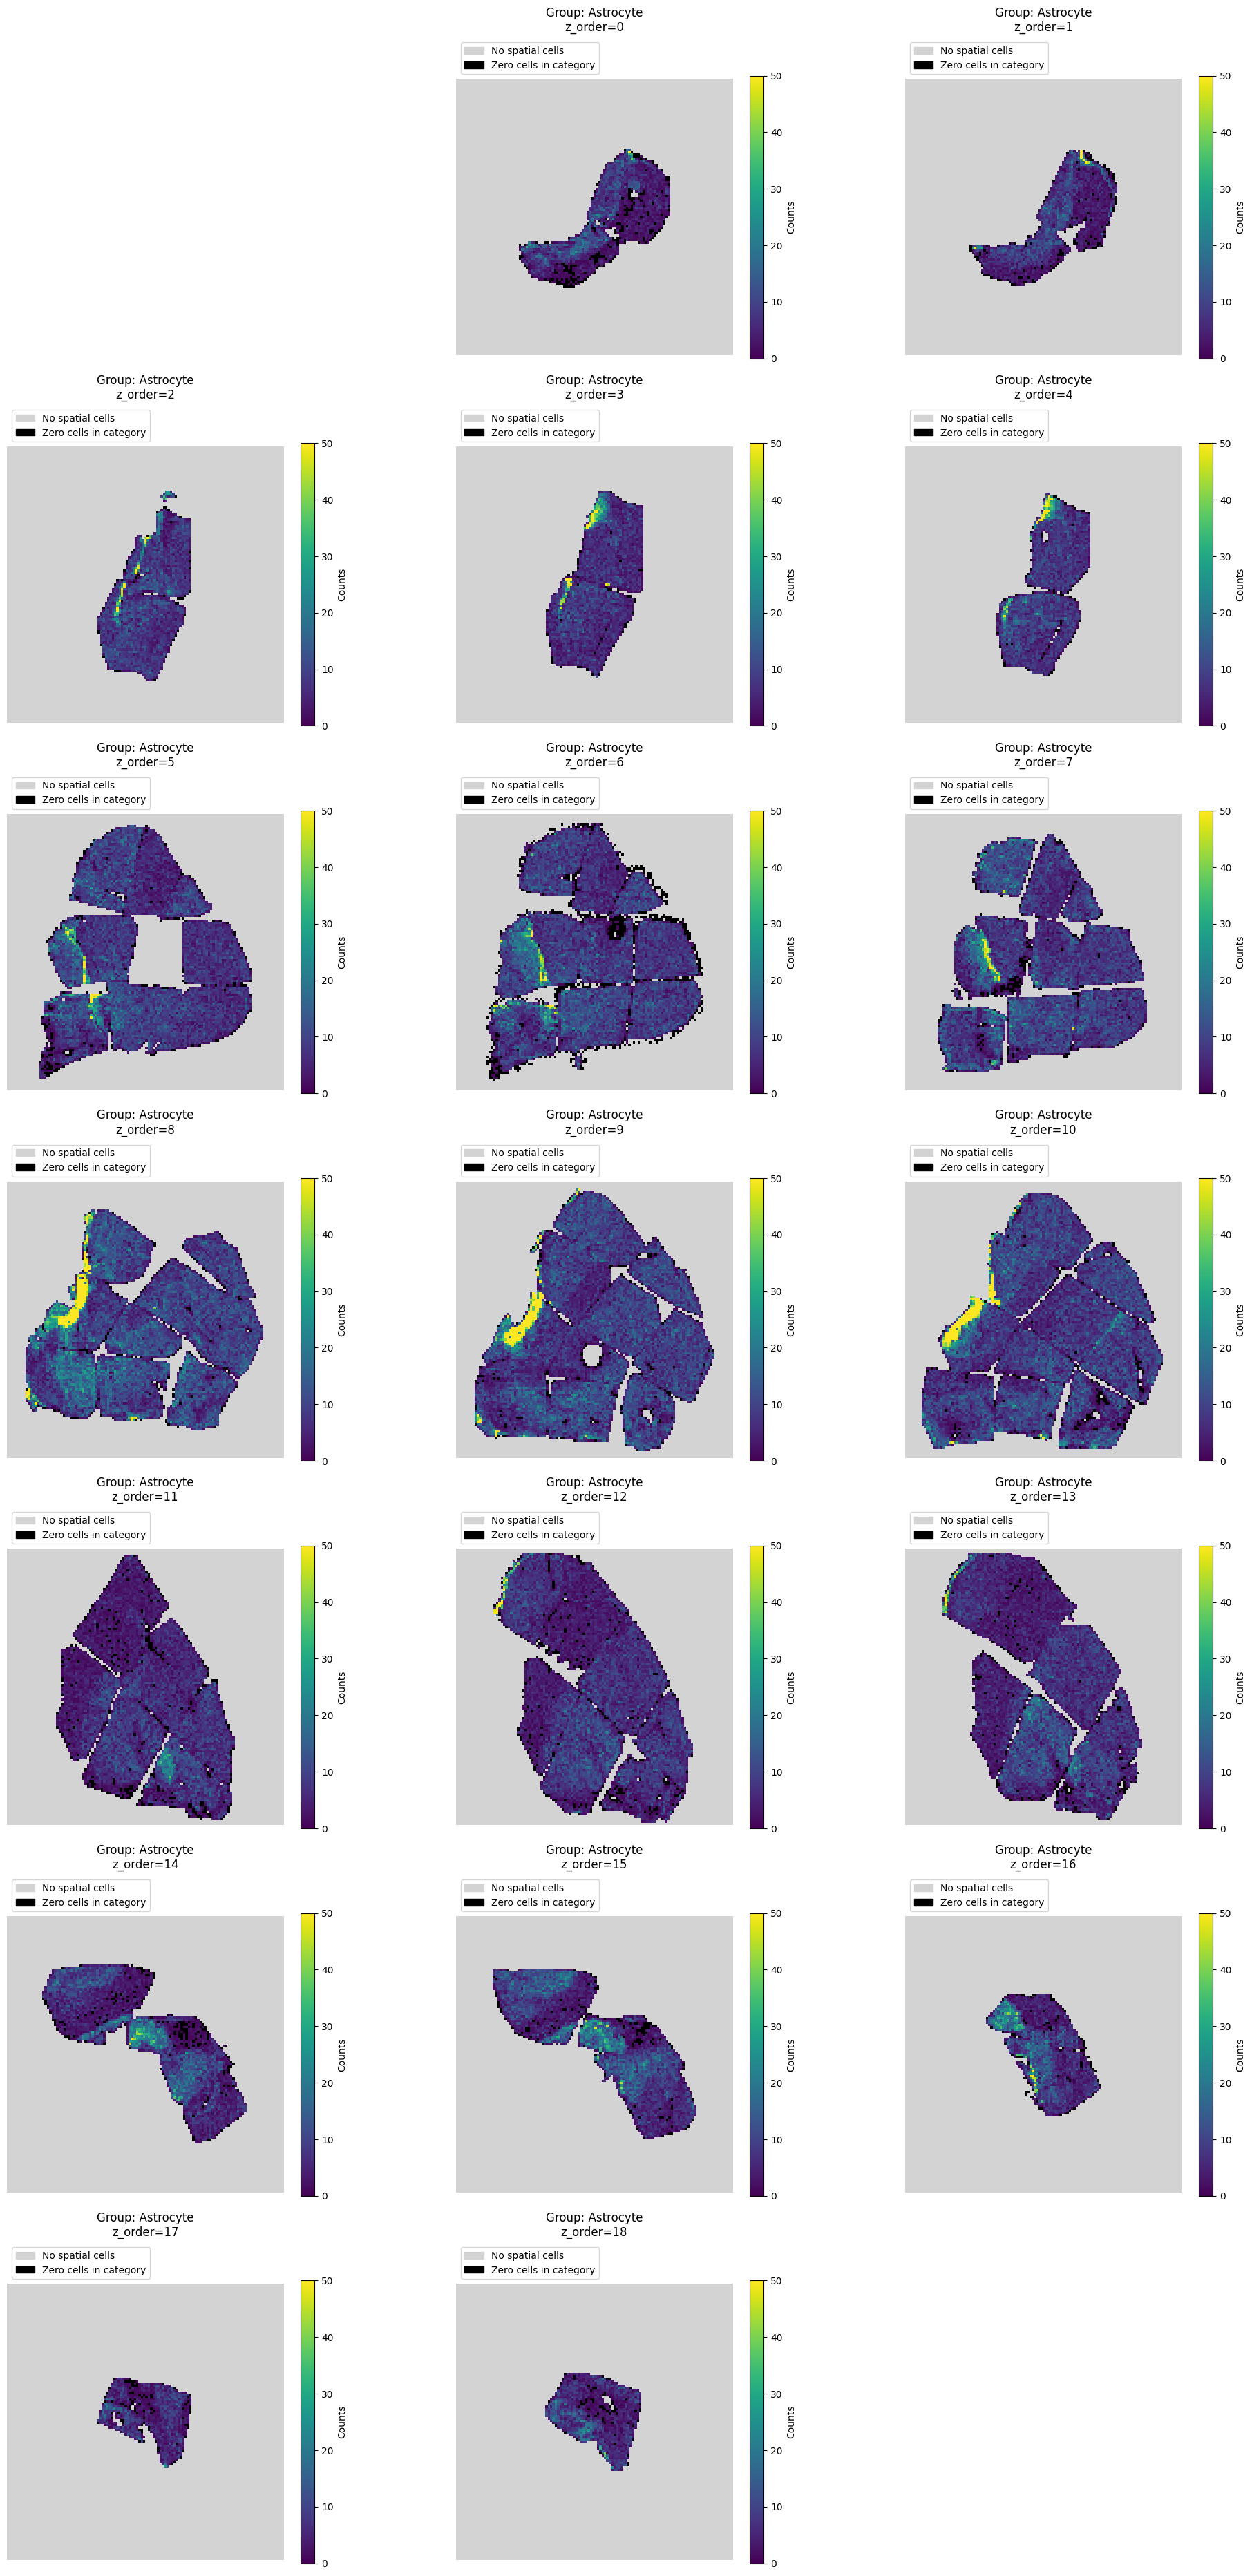

In [27]:
plt.close('all')

obs_field = 'Group'
category = 'Astrocyte'

astro_hist_1D_all = []
fig, axes = plt.subplots(int(np.ceil(len(adata_human.obs['z_order'].unique())/3)), 3, figsize=(20, 40))
axes = axes.flatten()
used_axes = []

for i, z in enumerate(sorted(adata_human.obs['z_order'].unique())):
    adata_sec = adata_human[adata_human.obs['z_order'] == z].copy()

    # some hacky axis things to get the subplots to look like the layout in .obsm['spatial_grid']
    ind = i+1  # first block/row also only has 2 sections; remaining have 3 sections
    ax = axes[ind]  
    used_axes.append(ind)

    # Calculate the # of astrocytes per bin in this section
    H_total, xedges_total, yedges_total = histplot.calculate_2D_histogram(
        adata_sec, 
        obs_field=obs_field, 
        category=category,  # None to get total counts
        binsize=300,
    )

    _ = histplot.plot_2D_histogram(
        H_total, 
        xedges_total, 
        yedges_total, 
        title=f'{obs_field}: {category}\nz_order={z}',
        ax=ax,
        cmap='viridis',
        vlims=(0,50),
        imshow_size=300*120,
        highlight_zero=True,
        # highlight_zero_color='black',  # highlight zero counts in black
    )

    # Append these total counts to a list
    astro_hist_1D_all.extend(H_total.flatten())

# delete unused axes
for j, ax in enumerate(axes):
    if j not in used_axes:
        fig.delaxes(ax)
        
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
plt.show()
# Convert the list to a numpy array for easier manipulation later
astro_hist_1D_all = np.array(astro_hist_1D_all)

# Save figure
os.makedirs('/results/figures_astro_distributions', exist_ok=True)
fig.savefig(
    '/results/figures_astro_distributions/astrocyte_spatial_histogram_absolute_count.png', 
    dpi=300,
    bbox_inches='tight',
)

# What are the counts of each Astrocyte cluster?

In [11]:
adata_human_astro = adata_human[adata_human.obs['Group'] == 'Astrocyte'].copy()

### Raw counts - astrocyte clusters

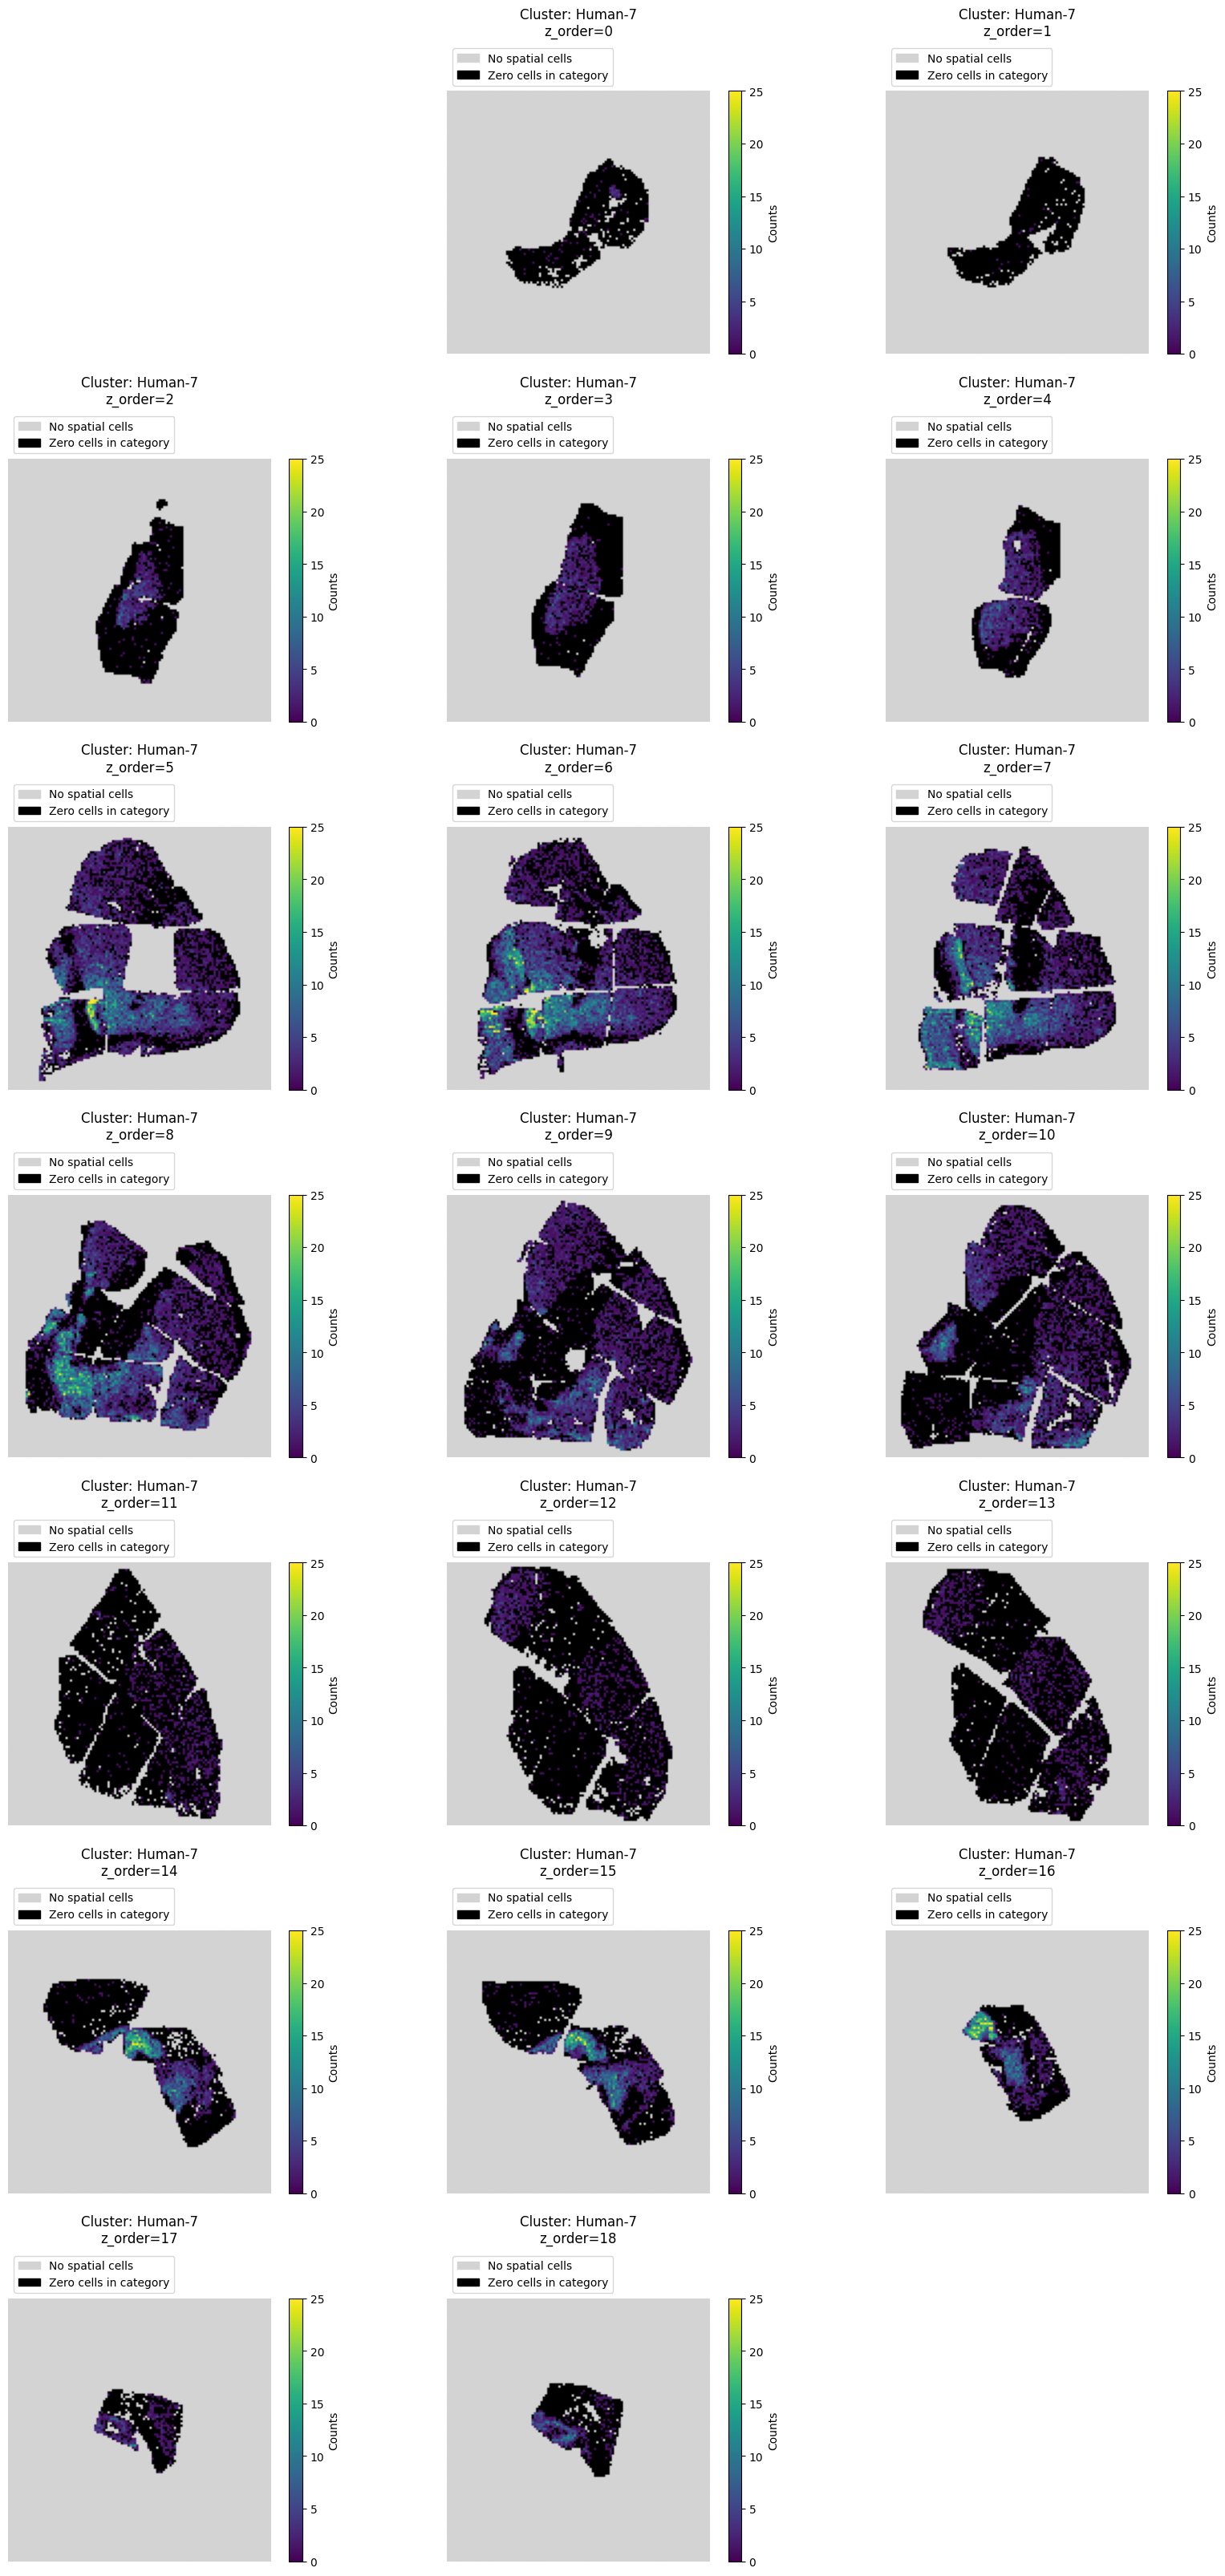

In [28]:
plt.close('all')

obs_field = 'Cluster'

for cat in adata_human_astro.obs[obs_field].cat.categories:
    fig, axes = plt.subplots(int(np.ceil(len(adata_human.obs['z_order'].unique())/3)), 3, figsize=(20, 40))
    axes = axes.flatten()
    used_axes = []

    for i, z in enumerate(sorted(adata_human_astro.obs['z_order'].unique())):
        adata_sec = adata_human_astro[adata_human_astro.obs['z_order'] == z].copy()

        # some hacky axis things to get the subplots to look like the layout in .obsm['spatial_grid']
        ind = i+1  # first block/row also only has 2 sections; remaining have 3 sections
        ax = axes[ind]  
        used_axes.append(ind)

        # Calculate the # of astrocytes per bin in this section
        H_total, xedges_total, yedges_total = histplot.calculate_2D_histogram(
            adata_sec, 
            obs_field=obs_field, 
            category=cat,  # None to get total counts
            binsize=300,
            normalization=None,  # No normalization for absolute counts
        )

        _ = histplot.plot_2D_histogram(
            H_total, 
            xedges_total, 
            yedges_total, 
            title=f'{obs_field}: {cat}\nz_order={z}',
            ax=ax,
            cmap='viridis',
            vlims=(0,25),
            imshow_size=300*120,
            highlight_zero = True, # highlight zeros in black
        )

    # clean up the unused axes
    for j, ax in enumerate(axes):
        if j not in used_axes:
            fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.4)

    # plt.suptitle(f'{obs_field} == {cat}')
    if cat==adata_human_astro.obs[obs_field].cat.categories[0]:
        plt.show()

    # Save the figure
    os.makedirs('/results/figures_astro_abs_counts', exist_ok=True)
    fig.savefig(
      f'/results/figures_astro_abs_counts/astrocyte_histogram_absolute_count_{obs_field}_{cat}.png', 
      dpi=300,
      bbox_inches='tight',
    )

## Astrocyte cluster distributions as proportion of all astrocytes

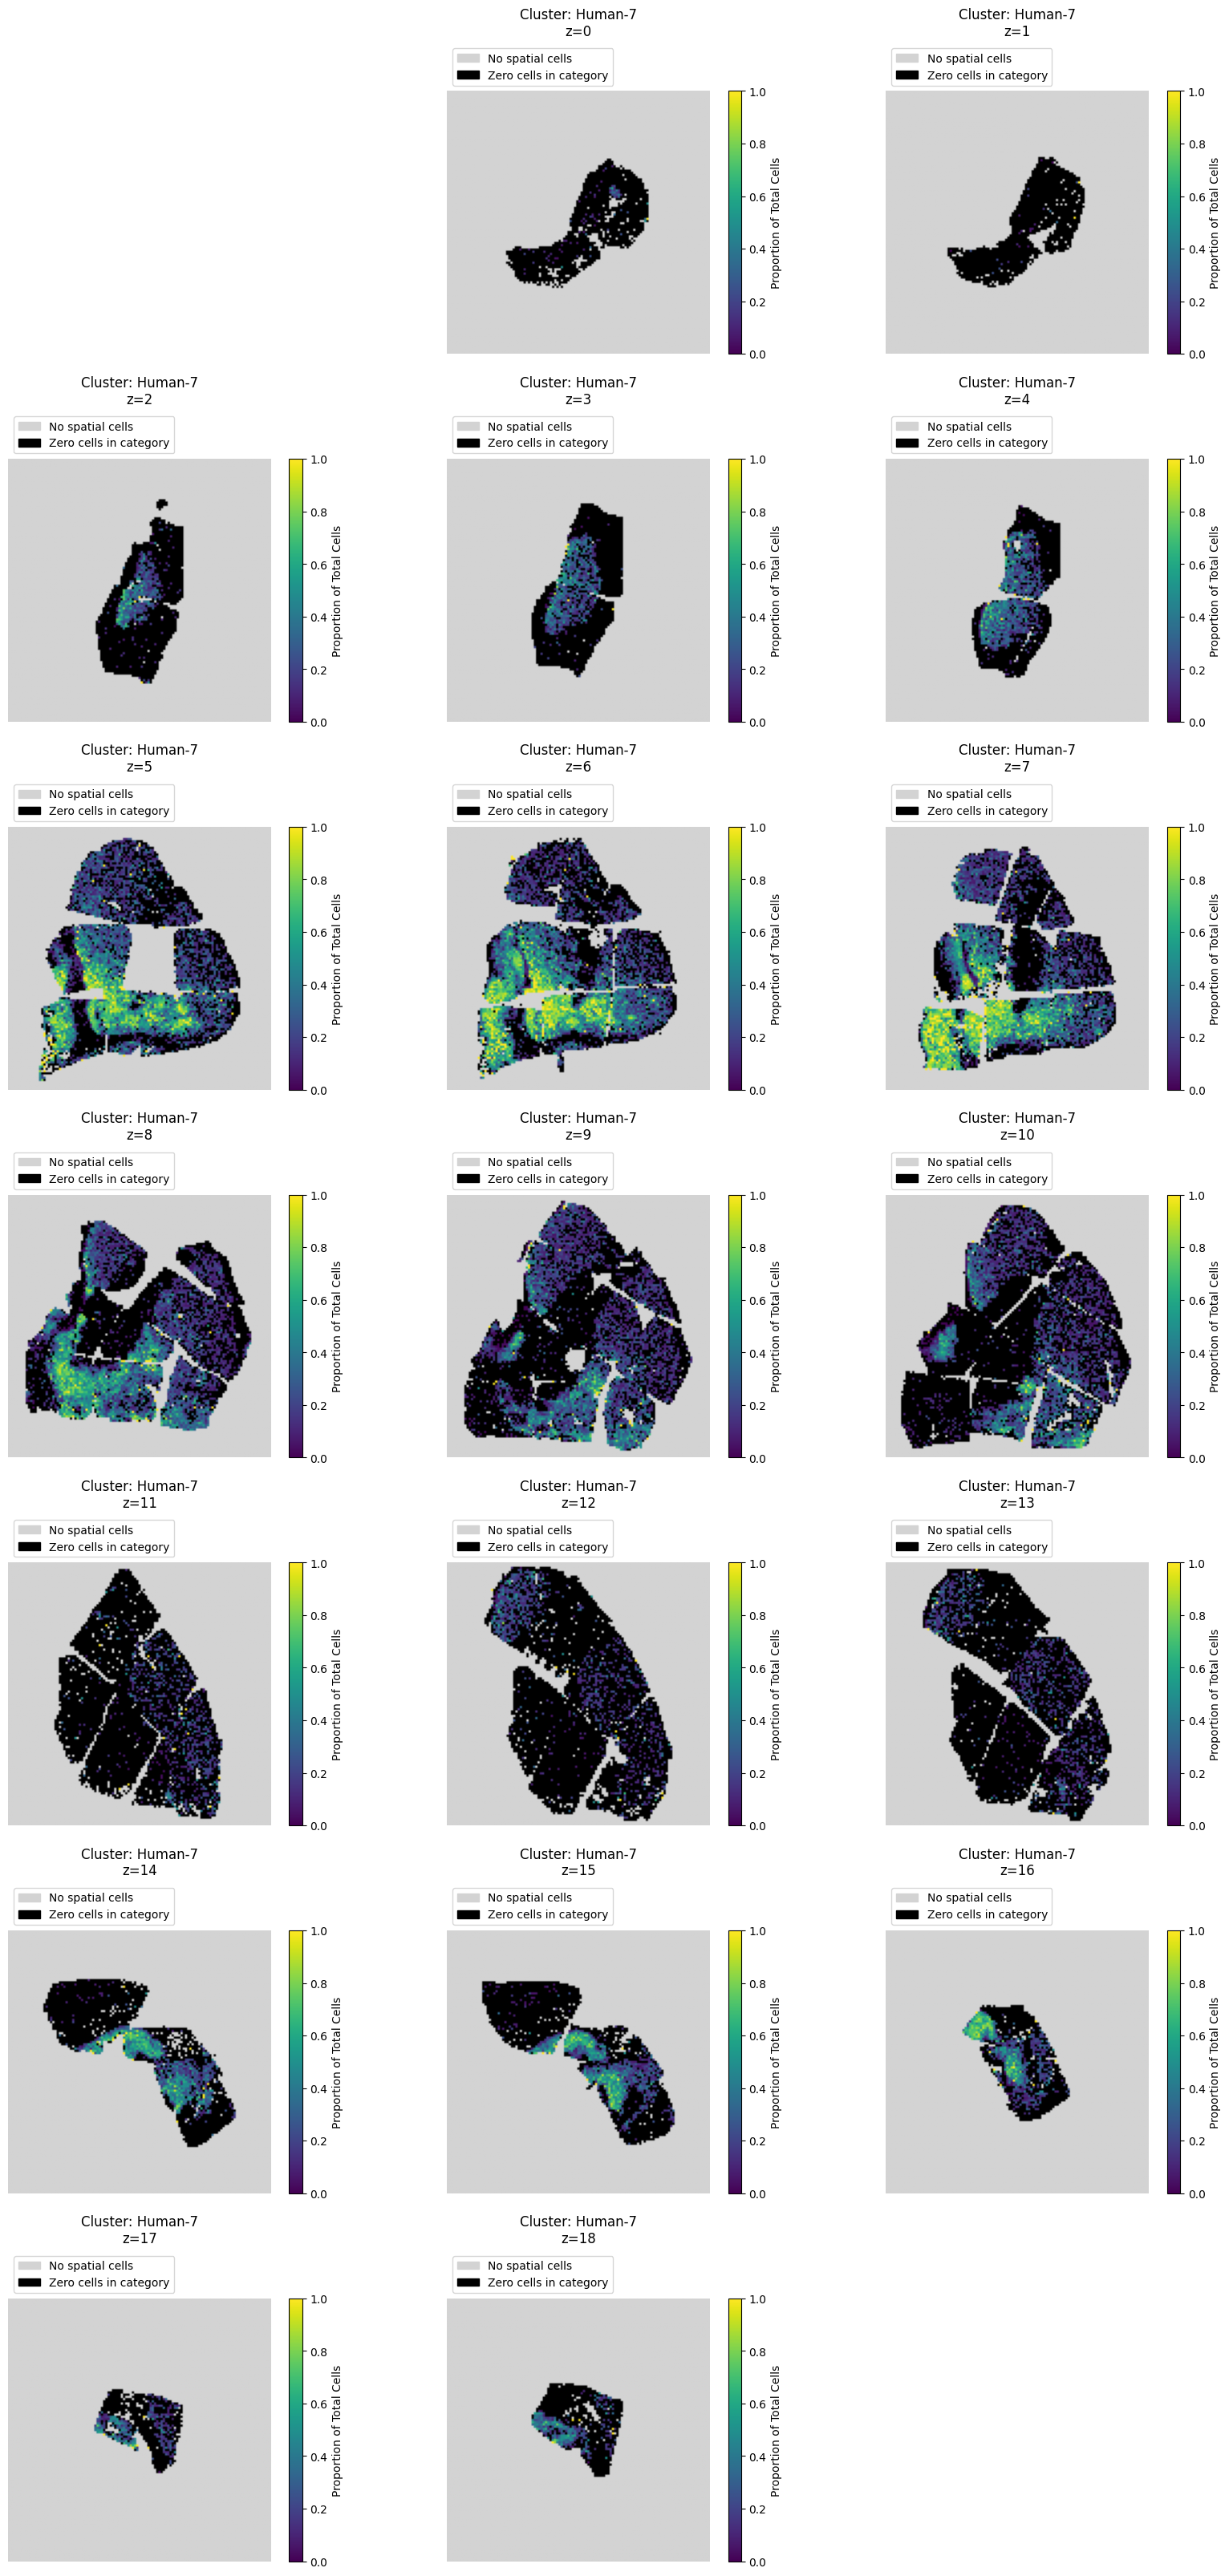

In [29]:
plt.close('all')

obs_field = 'Cluster'

for cat in adata_human_astro.obs[obs_field].cat.categories:
    fig, axes = plt.subplots(int(np.ceil(len(adata_human.obs['z_order'].unique())/3)), 3, figsize=(20, 40))
    axes = axes.flatten()
    used_axes = []

    for i, sec in enumerate(sorted(adata_human_astro.obs['z_order'].unique())):
        adata_sec = adata_human_astro[adata_human_astro.obs['z_order'] == sec].copy()

        # some hacky axis things to get the subplots to look like the layout in .obsm['spatial_grid']
        ind = i+1  # first block/row also only has 2 sections; remaining have 3 sections
        ax = axes[ind]  
        used_axes.append(ind)

        # Calculate the # of astrocytes per bin in this section
        H_total, xedges_total, yedges_total = histplot.calculate_2D_histogram(
            adata_sec, 
            obs_field=obs_field, 
            category=cat,  # None to get total counts
            binsize=300,
            normalization='proportion',  # No normalization for absolute counts
        )

        _ = histplot.plot_2D_histogram(
            H_total, 
            xedges_total, 
            yedges_total, 
            title=f'{obs_field}: {cat}\nz={sec}',
            ax=axes[i+1], # want to leave upper left empty
            cmap='viridis',
            # vlims=(0,1),
            imshow_size=300*120,
            highlight_zero = True, # highlight zeros in black
            normalization='proportion'
        )

    # delete unused axes
    for j, ax in enumerate(axes):
        if j not in used_axes:
            fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.4)

    # plt.suptitle(f'{obs_field} == {cat}')
    if cat == adata_human_astro.obs[obs_field].cat.categories[0]:
        plt.show()

    # Save the figure
    os.makedirs('/results/figures_astro_propotions', exist_ok=True)
    fig.savefig(
      f'/results/figures_astro_propotions/astrocyte_histogram_proportions_{obs_field}_{cat}.png', 
      dpi=300,
      bbox_inches='tight',
    )

# Enrichment of astroctye clusters

Enrichment = (per-bin proportion) / (global proportion)

In [30]:
# Calculate the overal proportion of astrocytes that belong to each astrocyte cluster
astro_cluster_proportions_global = adata_human_astro.obs.groupby('Cluster', observed=True).size() / adata_human_astro.shape[0]
astro_cluster_proportions_global = astro_cluster_proportions_global.to_dict()
astro_cluster_proportions_global

{'Human-7': 0.15397715650316585,
 'Human-14': 0.23397696621997688,
 'Human-28': 0.07631941570375445,
 'Human-31': 0.06848609109173394,
 'Human-143': 0.009187506640090447,
 'Human-145': 0.021051663471494786,
 'Human-146': 0.007059506310266254,
 'Human-149': 0.015484294501291547,
 'Human-150': 0.005161431500430516,
 'Human-152': 0.006276173849064203,
 'Human-159': 0.020579126885587475,
 'Human-160': 0.06935505098796617,
 'Human-227': 0.0010957140297380911,
 'Human-230': 0.02333664743220765,
 'Human-231': 0.07560743943841088,
 'Human-232': 0.05901791674793345,
 'Human-450': 0.02292753857595233,
 'Human-452': 0.004974319697957152,
 'Human-472': 0.022017350655446303,
 'Human-479': 0.08423519636432254,
 'Human-485': 0.01987349339320911}

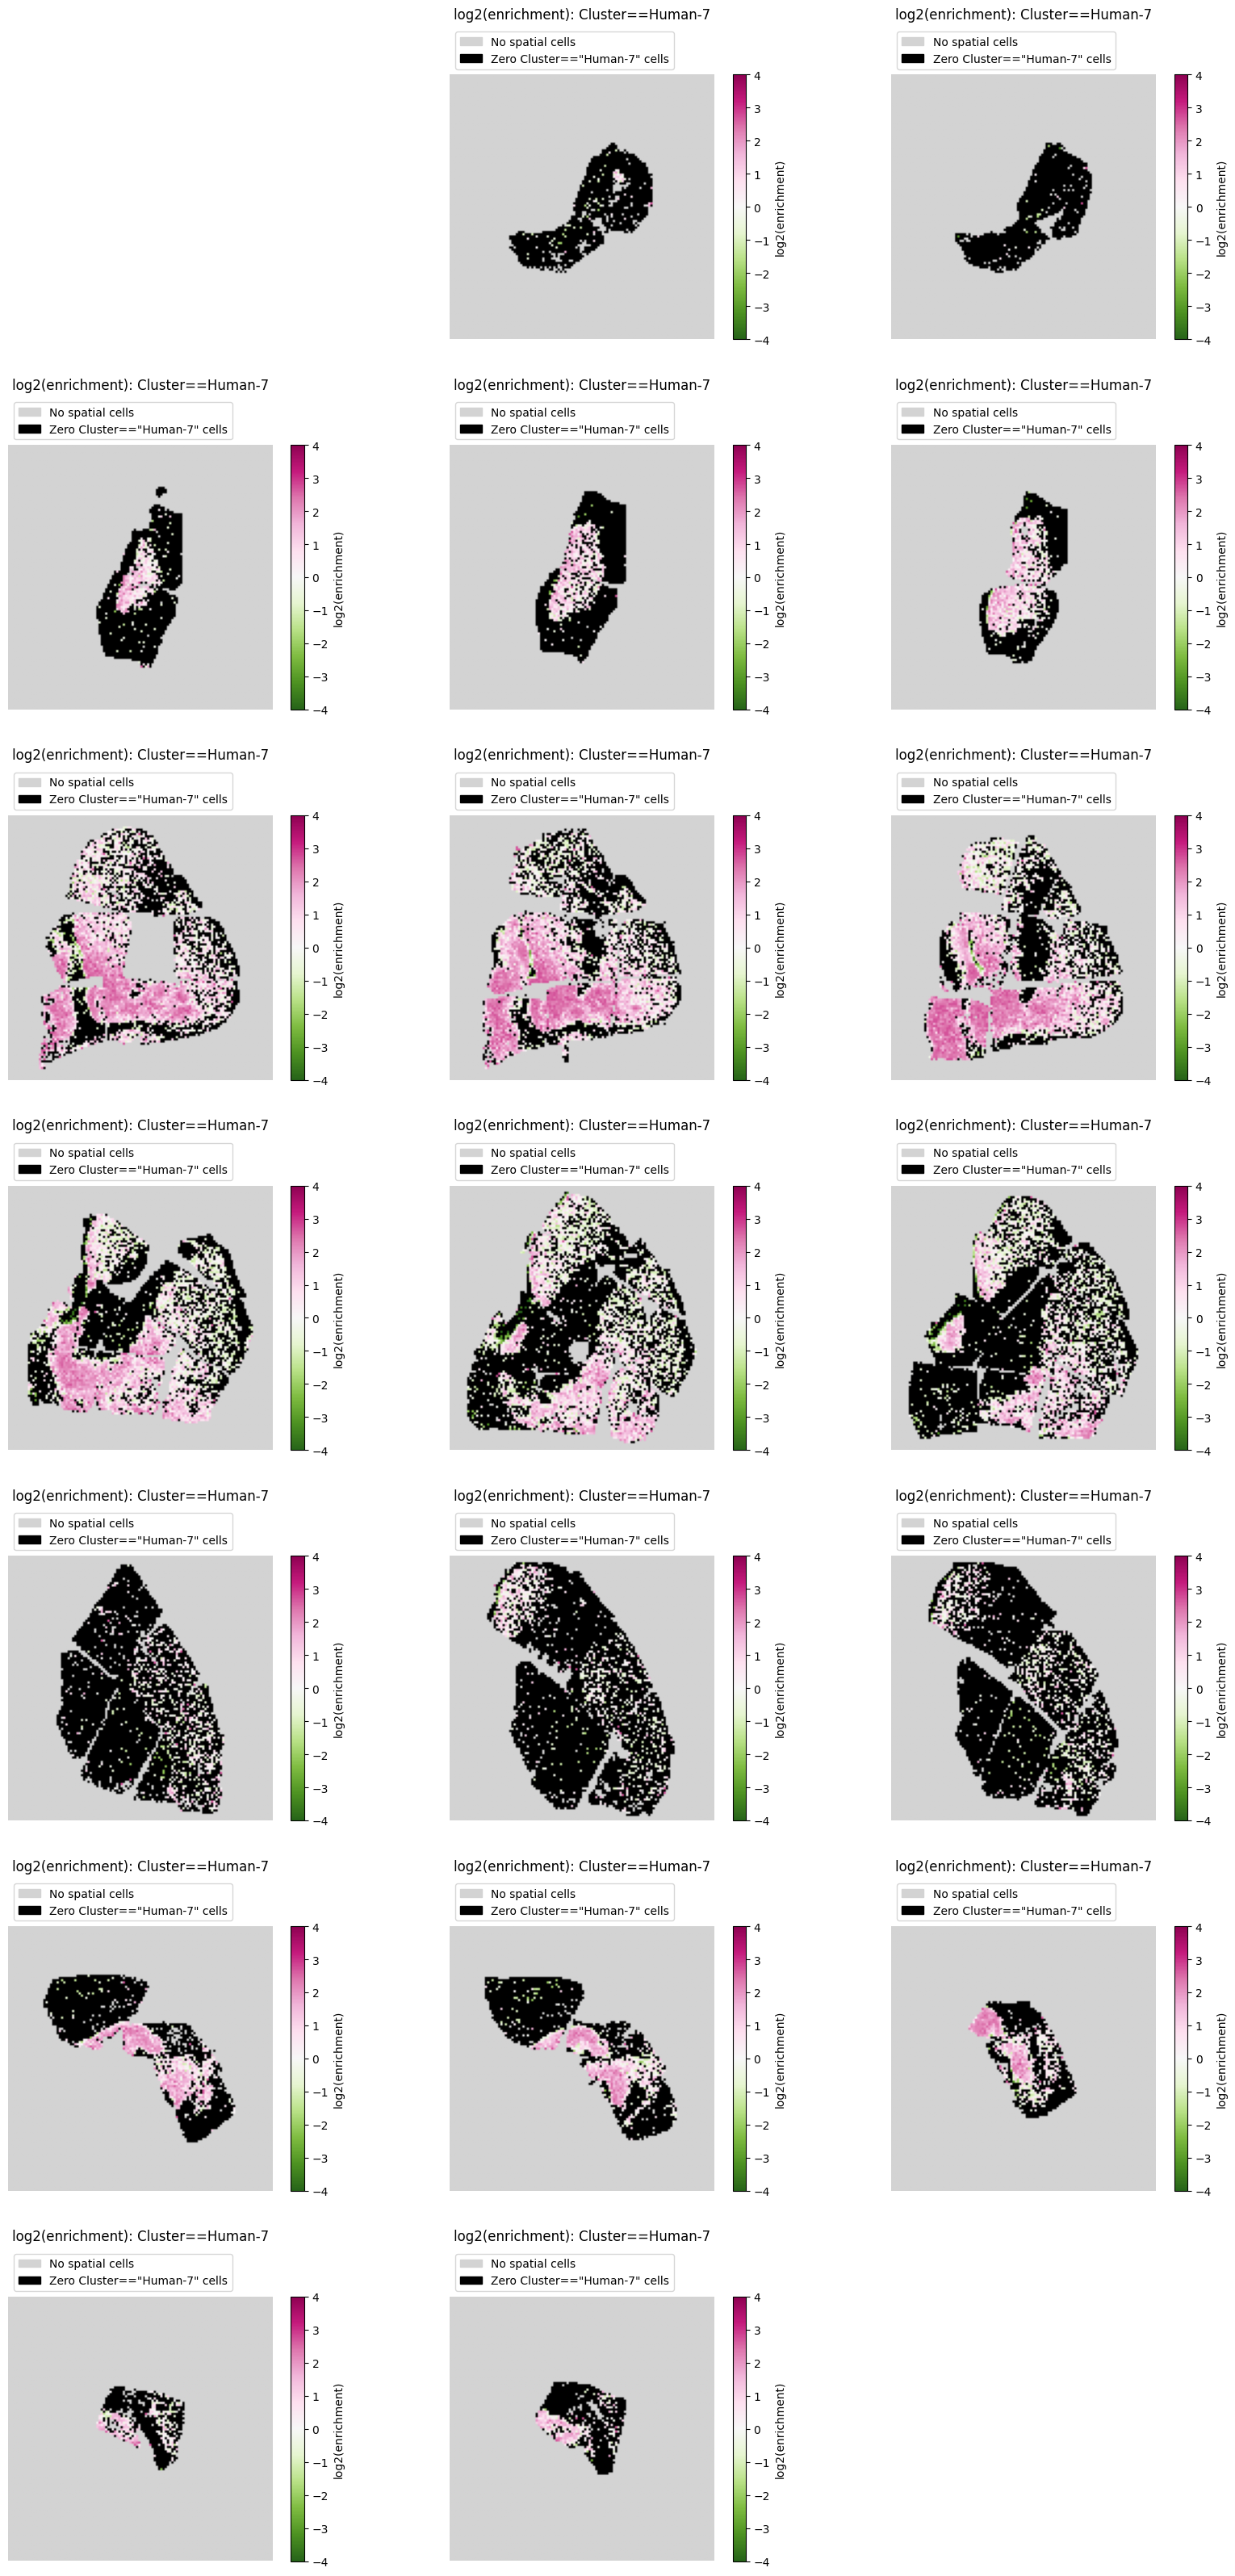

In [32]:
plt.close('all')

obs_field = 'Cluster'

for cat in adata_human_astro.obs[obs_field].cat.categories:
    fig, axes = plt.subplots(int(np.ceil(len(adata_human.obs['z_order'].unique())/3)), 3, figsize=(20, 40))
    axes = axes.flatten()
    used_axes = []

    for i, sec in enumerate(sorted(adata_human_astro.obs['z_order'].unique())):
        # print(f'z = {sec}')
        adata_sec = adata_human_astro[adata_human_astro.obs['z_order'] == sec].copy()
        # some hacky axis things to get the subplots to look like the layout in .obsm['spatial_grid']
        ind = i+1  # first block/row also only has 2 sections; remaining have 3 sections
        ax = axes[ind]
        used_axes.append(ind)

        _ = histplot.make_2D_hist_enrichment_log2(
            adata_sec, 
            obs_field=obs_field, 
            category=cat,  # None to get total counts
            coords_obsm_key='spatial_grid',
            binsize=300,
            imshow_size=300*120,
            global_propor_dict=astro_cluster_proportions_global,
            vlims=(-4,4),
            cmap='PiYG_r',
            no_cells_color="#d3d3d3", # light gray for bins with no cells
            no_category_color="black", # light beige for bins with cells but no category
            show_colorbar=True,
            ax=axes[i+1],  # want to leave upper left empty
        )
    
    # clean up unused axes
    for j, ax in enumerate(axes):
        if j not in used_axes:
            fig.delaxes(ax)

    # plt.suptitle(f'{obs_field} == {cat}')
    plt.subplots_adjust(hspace=0.4)

    if cat == adata_human_astro.obs[obs_field].cat.categories[0]:
        plt.show()

    # Save the figure
    os.makedirs('/results/figures_astro_enrichment', exist_ok=True)
    fig.savefig(
        f'/results/figures_astro_enrichment/astrocyte_histogram_enrichment_log2_allZ_{obs_field}_{cat}.png', 
        dpi=300,
        bbox_inches='tight',
    )